<a href="https://colab.research.google.com/github/hackazzo/Univ/blob/main/NetOpt/jupyter_notebooks/Set%20Covering-gurobi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Covering

Quanti bar dobbiamo aprire e dove per coprire tutti gli edifici dell'università a coppito??

In [ ]:
## Modules to be installed 
!pip install -i https://pypi.gurobi.com gurobipy 

import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# With this backend, the output of plotting commands is displayed inline within 
# frontends like the Jupyter notebook, directly below the code cell that produced it.
# The resulting plots will then also be stored in the notebook document.

%matplotlib inline 

## Campus map graph

In [ ]:
buildings = ['Delta6',
             'Hospital',
             'Block11A',
             'Block11E',
             'Coppito2',
             'Coppito1',
             'Block0',
             'StudentCenter',
             'Lab',
             'ComputerCenter']

G = nx.Graph() # creo il grafo
G.add_nodes_from(buildings) # aggiungo i nodi

# aggiungo gli archi
G.add_edge('Delta6','Hospital')
G.add_edge('Delta6','Block11A')
G.add_edge('Block11A','Hospital')
G.add_edge('Block11E','Hospital')
G.add_edge('Block11E','Coppito2')
G.add_edge('Coppito1','Coppito2')
G.add_edge('StudentCenter','Coppito2')
G.add_edge('Coppito1','StudentCenter')
G.add_edge('StudentCenter','Lab')
G.add_edge('StudentCenter','Block0')
G.add_edge('Lab','ComputerCenter')
G.add_edge('ComputerCenter','StudentCenter')
G.add_edge('Coppito1','Block0')
G.add_edge('Block0','Lab')
G.add_edge('Lab','ComputerCenter')
G.add_edge('ComputerCenter','Block0')



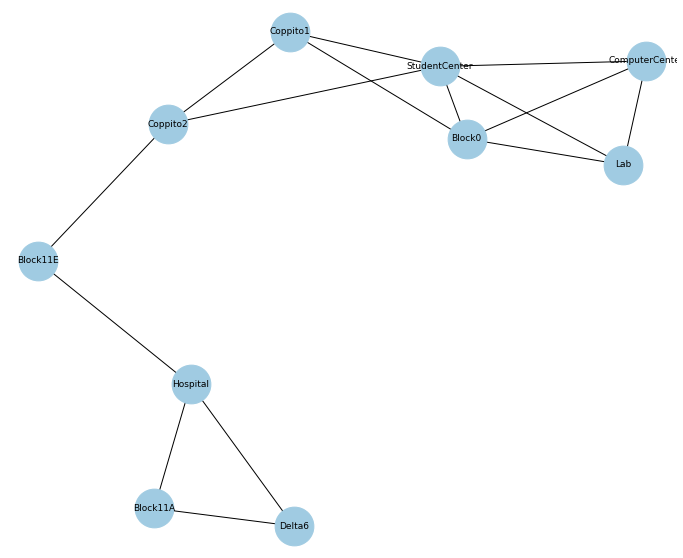

In [ ]:
# disegnamo il grafo 

pos = nx.spring_layout(G, k=1, seed=10) # genera 10 posizioni per disegnare i nodi

fig, ax = plt.subplots(1, 1, figsize=(12,10))

nx.draw(G,
        pos,
        ax,
        node_color='#A0CBE2',
        width=1,
        node_size=1500,
        with_labels=True,
        font_size=9,
        font_color='k')

In [ ]:
# creo un dizionario con tutti i vicini dei nodi
subsets = dict()

# G.neighbors('Delta6') ritorna un iteratore
 # il ''+i' aggiunge il nodo stesso oalla lista dei suoi vicini
subsets = {i : list(G.neighbors(i)) + [i] for i in G.nodes()} 
subsets

{'Block0': ['StudentCenter', 'Coppito1', 'Lab', 'ComputerCenter', 'Block0'],
 'Block11A': ['Delta6', 'Hospital', 'Block11A'],
 'Block11E': ['Hospital', 'Coppito2', 'Block11E'],
 'ComputerCenter': ['Lab', 'StudentCenter', 'Block0', 'ComputerCenter'],
 'Coppito1': ['Coppito2', 'StudentCenter', 'Block0', 'Coppito1'],
 'Coppito2': ['Block11E', 'Coppito1', 'StudentCenter', 'Coppito2'],
 'Delta6': ['Hospital', 'Block11A', 'Delta6'],
 'Hospital': ['Delta6', 'Block11A', 'Block11E', 'Hospital'],
 'Lab': ['StudentCenter', 'ComputerCenter', 'Block0', 'Lab'],
 'StudentCenter': ['Coppito2',
  'Coppito1',
  'Lab',
  'Block0',
  'ComputerCenter',
  'StudentCenter']}

## Matrice di Incidenza A mxn
Sulle righe abbiamo gli n edifici e sulle colonne gli m vicini

\begin{array}{c|ccccccccc}
  & \texttt{Delta6} & \texttt{Hospital} & \texttt{Block11A} & \texttt{Block11E} & \texttt{Coppito2} 
  & \texttt{Coppito1} & \texttt{Block0} & \texttt{Lab} & \texttt{ComputerCenter} & \texttt{StudentCenter}\\
  \hline
\texttt{Delta6}   & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\texttt{Hospital} & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
\texttt{Block11A} & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\texttt{Block11E} & 0 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
\texttt{Coppito2} & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 1\\
\texttt{Coppito1} & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 1\\
\texttt{Block0}   & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1\\
\texttt{Lab}      & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1\\
\texttt{ComputerCenter} & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1\\
\texttt{StudentCenter} & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1\\
\end{array}

## Decision variables



$$x_i = \begin{cases} 1 \text{ if subset } i \text { is selected (if the facility is opened on building $i$) }\\ 0 \text{ otherwise.}  \end{cases}$$

In [ ]:
setcovering = gb.Model() # creiamo il modello
x = setcovering.addVars(buildings, vtype = gb.GRB.BINARY, name = 'x') # aggiungiamo le variabili binarie per i nodi
setcovering.update()
x

{'Block0': <gurobi.Var x[Block0]>,
 'Block11A': <gurobi.Var x[Block11A]>,
 'Block11E': <gurobi.Var x[Block11E]>,
 'ComputerCenter': <gurobi.Var x[ComputerCenter]>,
 'Coppito1': <gurobi.Var x[Coppito1]>,
 'Coppito2': <gurobi.Var x[Coppito2]>,
 'Delta6': <gurobi.Var x[Delta6]>,
 'Hospital': <gurobi.Var x[Hospital]>,
 'Lab': <gurobi.Var x[Lab]>,
 'StudentCenter': <gurobi.Var x[StudentCenter]>}

## Objective function e Constraints 
Objective => minimizzare il numero di bar

Constraint di copertura => ogni struttura deve essere coperta da un Bar

$$
\sum_{i \in S(j)} x_i \ge 1 \;\;\; j \in V
$$

In [ ]:
setcovering.setObjective(x.sum(), gb.GRB.MINIMIZE) # objective funct

setcovering.addConstrs((x.sum(subsets[j]) >=1 for j in subsets),name='Cover') # costraint

# write su file il problema
setcovering.update()
setcovering.write('setcov.lp')

In [ ]:
# risolviamo il problema
setcovering.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 10 rows, 10 columns and 40 nonzeros
Model fingerprint: 0xb7ebd306
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 10 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 2 available processors)

Solution count 2: 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%


In [ ]:
# Stampiamo la soluzione
print('Number of activated facilities: %g' % setcovering.objVal) # objval contiene il numero di variabili settate a 1
print('Activated facilities:')

activated = list()
# x è il nostro insieme di variabili, il metodo items() ritorna la coppia {var, val}
for name, var in x.items(): 
    if var.x > 0.1:
        activated.append(name)
        print (name)

Number of activated facilities: 2
Activated facilities:
[('Delta6', <gurobi.Var x[Delta6] (value 0.0)>), ('Hospital', <gurobi.Var x[Hospital] (value 1.0)>), ('Block11A', <gurobi.Var x[Block11A] (value 0.0)>), ('Block11E', <gurobi.Var x[Block11E] (value 0.0)>), ('Coppito2', <gurobi.Var x[Coppito2] (value 0.0)>), ('Coppito1', <gurobi.Var x[Coppito1] (value 0.0)>), ('Block0', <gurobi.Var x[Block0] (value 0.0)>), ('StudentCenter', <gurobi.Var x[StudentCenter] (value 1.0)>), ('Lab', <gurobi.Var x[Lab] (value 0.0)>), ('ComputerCenter', <gurobi.Var x[ComputerCenter] (value 0.0)>)]
Hospital
StudentCenter


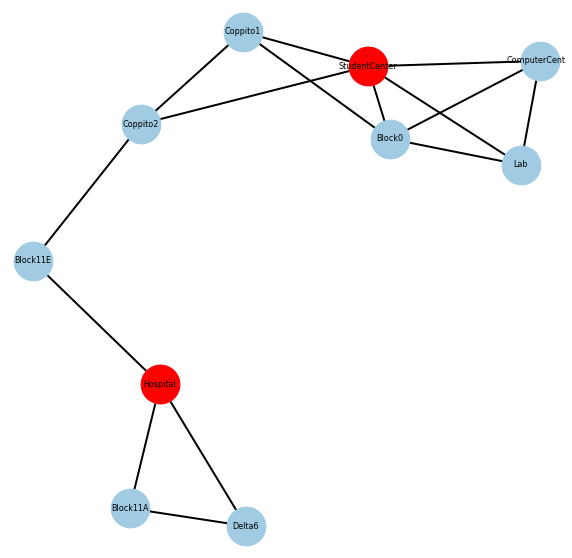

In [ ]:
# disegnamo la soluzione sul grafo
fig, ax = plt.subplots(1, 1, figsize=(10,10))


# disegno il grafo 
nx.draw(G, pos, node_color='#A0CBE2',width=2,node_size=1500,
        with_labels=True, font_size=8)

# ridisegno i nodi attivati colorati di rosso, sopra al grafo
nx.draw_networkx_nodes(G, pos, nodelist=activated, node_size=1500, node_color ='r')